Epoch 1/200


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.2411 - val_loss: 0.1185
Epoch 2/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1255 - val_loss: 0.1472
Epoch 3/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0750 - val_loss: 0.1011
Epoch 4/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0677 - val_loss: 0.0893
Epoch 5/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0659 - val_loss: 0.0994
Epoch 6/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0615 - val_loss: 0.0738
Epoch 7/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0585 - val_loss: 0.0946
Epoch 8/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0511 - val_loss: 0.0735
Epoch 9/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0591 - val_loss: 0.0714
Epoch 10/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0536 - val_loss: 0.0851
Epoch 11/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0504 - val_loss: 0.0658
Epoch 12/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0467 - val_loss: 0.0809
Epoch 13/200

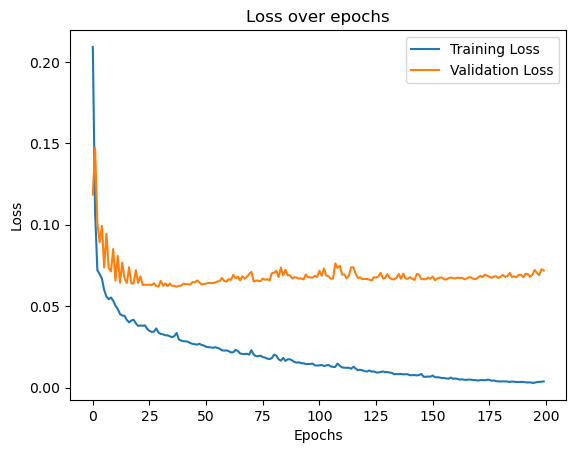

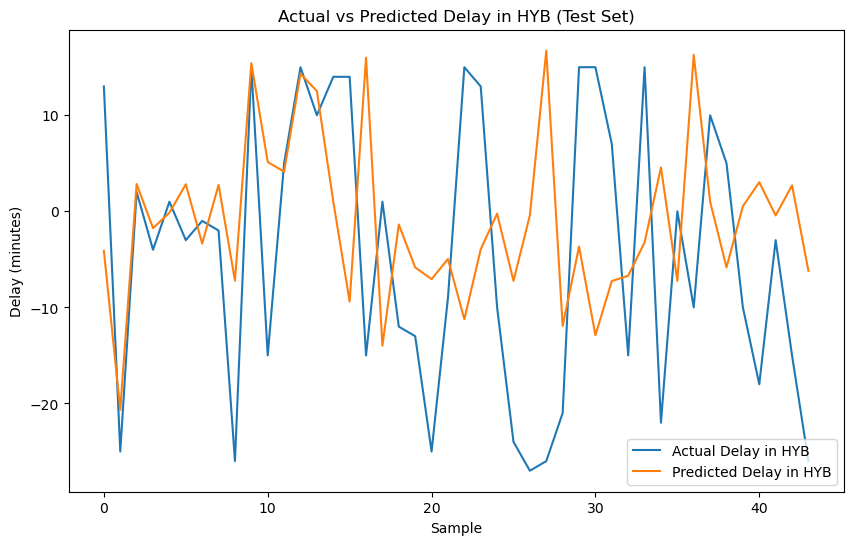

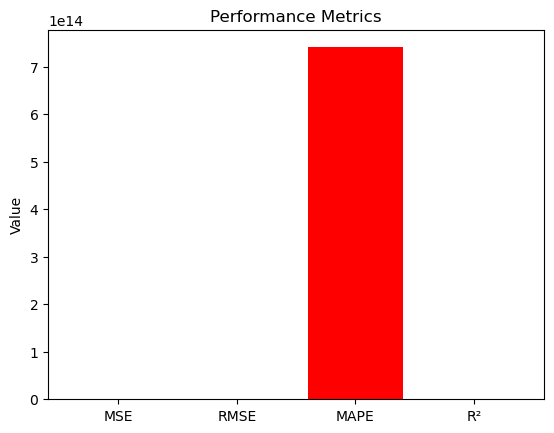

MSE:  276.3618401512774
RMSE:  16.62413426772286
MAPE:  740965219970701.0
R²:  -0.3492760368109651


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

# Load the dataset
data = pd.read_csv('new_data2.csv')

# Drop the date column and set X, y
data = data.drop(columns=['date(dd/mm/yy)'])
X = data.drop(columns=['HYB'])
y = data['HYB']

# Outlier removal using IQR
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers from the target column ('HYB')
data_cleaned = remove_outliers_iqr(data, 'HYB')

# You can also remove outliers from the other feature columns if needed
for col in X.columns:
    data_cleaned = remove_outliers_iqr(data_cleaned, col)

# Set X and y again after outlier removal
X = data_cleaned.drop(columns=['HYB']).values
y = data_cleaned['HYB'].values

# Scaling with MinMaxScaler
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Train-test split (80% training, 20% testing)
train_size = int(0.8 * len(X_scaled))
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

# Reshape X for RNN (samples, timesteps, features)
X_train_rnn = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_rnn = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build the RNN model
model = Sequential()
model.add(SimpleRNN(100, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2]), activation='relu'))
model.add(Dense(1))  # Output layer for regression

model.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
history = model.fit(X_train_rnn, y_train, epochs=200, batch_size=32, validation_data=(X_test_rnn, y_test))

# Predictions on test set
predictions_scaled = model.predict(X_test_rnn)
predictions = scaler_y.inverse_transform(predictions_scaled)  # Inverse transform predictions
y_test_rescaled = scaler_y.inverse_transform(y_test)          # Inverse transform y_test

# Calculating Metrics on test set
mse = mean_squared_error(y_test_rescaled, predictions)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test_rescaled, predictions)
r2 = r2_score(y_test_rescaled, predictions)

# Print Metrics
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}')
print(f'R-Squared (R²): {r2}')

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot predictions vs actual on test set
plt.figure(figsize=(10,6))
plt.plot(y_test_rescaled, label='Actual Delay in HYB')
plt.plot(predictions, label='Predicted Delay in HYB')
plt.title('Actual vs Predicted Delay in HYB (Test Set)')
plt.xlabel('Sample')
plt.ylabel('Delay (minutes)')
plt.legend()
plt.show()

# Plot the MSE, RMSE, MAPE, R² on a bar chart
metrics = ['MSE', 'RMSE', 'MAPE', 'R²']
values = [mse, rmse, mape, r2]

plt.bar(metrics, values, color=['blue', 'green', 'red', 'orange'])
plt.title('Performance Metrics')
plt.ylabel('Value')
plt.show()

print('MSE: ',mse)
print('RMSE: ',rmse)
print('MAPE: ',mape)
print('R²: ',r2)

Epoch 1/200


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.5065 - val_loss: 0.2955
Epoch 2/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3098 - val_loss: 0.0864
Epoch 3/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1530 - val_loss: 0.1066
Epoch 4/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0884 - val_loss: 0.2632
Epoch 5/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1043 - val_loss: 0.2179
Epoch 6/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0940 - val_loss: 0.1321
Epoch 7/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0631 - val_loss: 0.0965
Epoch 8/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0849 - val_loss: 0.0904
Epoch 9/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0740 - val_loss: 0.0976
Epoch 10/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0686 - val_loss: 0.1040
Epoch 11/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0672 - val_loss: 0.1038
Epoch 12/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0641 - val_loss: 0.0979
Epoch 13/200

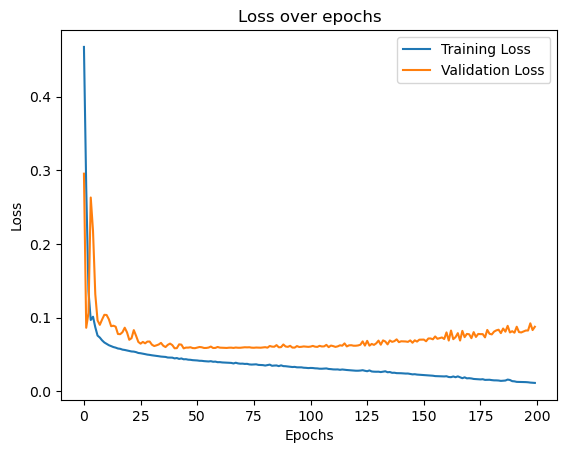

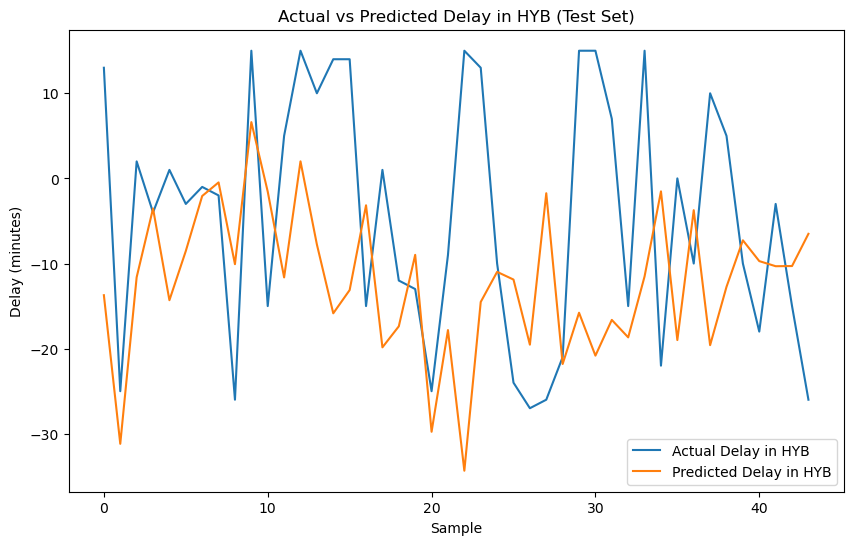

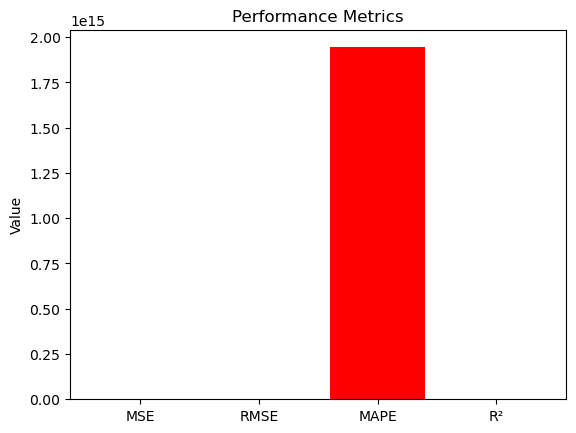

MSE:  337.4814937205981
RMSE:  18.370669386840483
MAPE:  1943899269782809.5
R²:  -0.6476793326282548


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load the dataset
data = pd.read_csv('new_data2.csv')

# Drop the date column and set X, y
data = data.drop(columns=['date(dd/mm/yy)'])
X = data.drop(columns=['HYB'])
y = data['HYB']

# Outlier removal using IQR
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers from the target column ('HYB')
data_cleaned = remove_outliers_iqr(data, 'HYB')

# You can also remove outliers from the other feature columns if needed
for col in X.columns:
    data_cleaned = remove_outliers_iqr(data_cleaned, col)

# Set X and y again after outlier removal
X = data_cleaned.drop(columns=['HYB']).values
y = data_cleaned['HYB'].values

# Scaling with MinMaxScaler
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Train-test split (80% training, 20% testing)
train_size = int(0.8 * len(X_scaled))
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

# Reshape X for LSTM (samples, timesteps, features)
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), activation='relu'))
model.add(Dense(1))  # Output layer for regression

model.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
history = model.fit(X_train_lstm, y_train, epochs=200, batch_size=32, validation_data=(X_test_lstm, y_test))

# Predictions on test set
predictions_scaled = model.predict(X_test_lstm)
predictions = scaler_y.inverse_transform(predictions_scaled)  # Inverse transform predictions
y_test_rescaled = scaler_y.inverse_transform(y_test)          # Inverse transform y_test

# Calculating Metrics on test set
mse = mean_squared_error(y_test_rescaled, predictions)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test_rescaled, predictions)
r2 = r2_score(y_test_rescaled, predictions)

# Print Metrics
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}')
print(f'R-Squared (R²): {r2}')

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot predictions vs actual on test set
plt.figure(figsize=(10,6))
plt.plot(y_test_rescaled, label='Actual Delay in HYB')
plt.plot(predictions, label='Predicted Delay in HYB')
plt.title('Actual vs Predicted Delay in HYB (Test Set)')
plt.xlabel('Sample')
plt.ylabel('Delay (minutes)')
plt.legend()
plt.show()

# Plot the MSE, RMSE, MAPE, R² on a bar chart
metrics = ['MSE', 'RMSE', 'MAPE', 'R²']
values = [mse, rmse, mape, r2]

plt.bar(metrics, values, color=['blue', 'green', 'red', 'orange'])
plt.title('Performance Metrics')
plt.ylabel('Value')
plt.show()

print('MSE: ',mse)
print('RMSE: ',rmse)
print('MAPE: ',mape)
print('R²: ',r2)

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Load the dataset
data = pd.read_csv('new_data2.csv')

# Drop the date column and set X, y
data = data.drop(columns=['date(dd/mm/yy)'])

# Creating lag features (shifted versions of the target 'HYB')
def create_lag_features(data, column, n_lags=3):
    for lag in range(1, n_lags + 1):
        data[f'{column}_lag{lag}'] = data[column].shift(lag)
    return data

# Adding lag features for 'HYB' (target column)
data_lagged = create_lag_features(data, 'HYB', n_lags=3)
data_lagged = data_lagged.dropna()  # Drop NaN values created by lagging

# Set X and y again after creating lag features
X = data_lagged.drop(columns=['HYB']).values
y = data_lagged['HYB'].values

# Scaling with MinMaxScaler
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Train-test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Reshape X for LSTM (samples, timesteps, features)
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build an improved LSTM model with additional complexity
model_improved_v2 = Sequential()
model_improved_v2.add(LSTM(200, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), activation='tanh'))
model_improved_v2.add(Dropout(0.3))
model_improved_v2.add(LSTM(100, activation='tanh'))
model_improved_v2.add(Dropout(0.3))
model_improved_v2.add(Dense(1))  # Output layer for regression

# Compile the model with a different optimizer and learning rate
optimizer_v2 = Adam(learning_rate=0.0005)
model_improved_v2.compile(optimizer=optimizer_v2, loss='mean_squared_error')

# Fit the model
history_improved_v2 = model_improved_v2.fit(X_train_lstm, y_train, epochs=300, batch_size=16, validation_data=(X_test_lstm, y_test))

# Predictions on the test set
predictions_scaled_v2 = model_improved_v2.predict(X_test_lstm)
predictions_v2 = scaler_y.inverse_transform(predictions_scaled_v2)  # Inverse transform predictions
y_test_rescaled_v2 = scaler_y.inverse_transform(y_test)  # Inverse transform y_test

# Calculating Metrics on test set
mse_v2 = mean_squared_error(y_test_rescaled_v2, predictions_v2)
rmse_v2 = np.sqrt(mse_v2)
mape_v2 = mean_absolute_percentage_error(y_test_rescaled_v2, predictions_v2)
r2_v2 = r2_score(y_test_rescaled_v2, predictions_v2)

print(f'Mean Squared Error (MSE): {mse_v2}')
print(f'Root Mean Squared Error (RMSE): {rmse_v2}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_v2}')
print(f'R-Squared (R²): {r2_v2}')

print('MSE: ',mse)
print('RMSE: ',rmse)
print('MAPE: ',mape)
print('R²: ',r2)

Epoch 1/300


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0138 - val_loss: 0.0146
Epoch 2/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0063 - val_loss: 0.0140
Epoch 3/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0048 - val_loss: 0.0136
Epoch 4/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0047 - val_loss: 0.0133
Epoch 5/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0039 - val_loss: 0.0135
Epoch 6/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0052 - val_loss: 0.0136
Epoch 7/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0037 - val_loss: 0.0134
Epoch 8/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0036 - val_loss: 0.0133
Epoch 9/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0039 - val_loss: 0.0129
Epoch 10/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0035 - val_loss: 0.0139
Epoch 11/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0045 - val_loss: 0.0129
Epoch 12/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0042 - val_l

Epoch 1/300


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0133 - val_loss: 0.0147
Epoch 2/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0056 - val_loss: 0.0140
Epoch 3/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0051 - val_loss: 0.0136
Epoch 4/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0034 - val_loss: 0.0134
Epoch 5/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0043 - val_loss: 0.0137
Epoch 6/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0053 - val_loss: 0.0134
Epoch 7/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0036 - val_loss: 0.0132
Epoch 8/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0131
Epoch 9/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0043 - val_loss: 0.0131
Epoch 10/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0034 - val_loss: 0.0129
Epoch 11/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0127
Epoch 12/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0032 - val_l

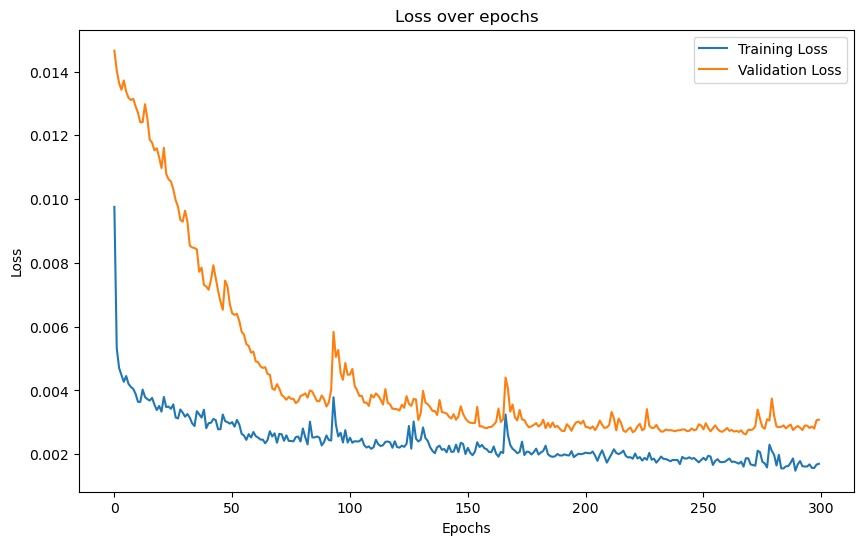

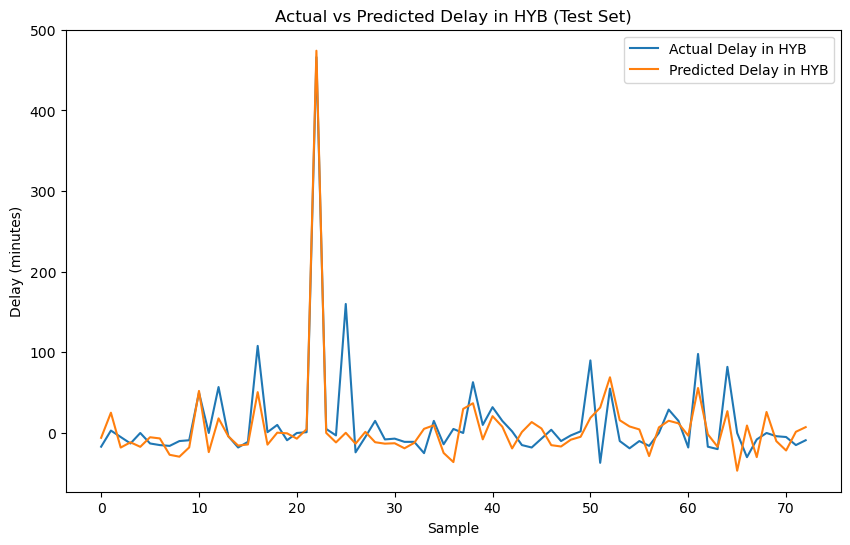

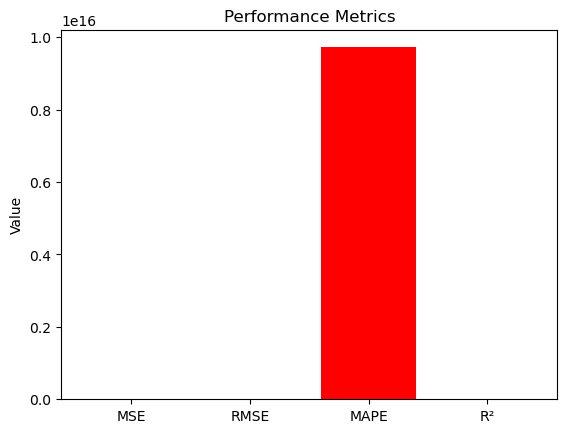

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Load the dataset
data = pd.read_csv('new_data2.csv')

# Drop the date column and set X, y
data = data.drop(columns=['date(dd/mm/yy)'])

# Creating lag features (shifted versions of the target 'HYB')
def create_lag_features(data, column, n_lags=3):
    for lag in range(1, n_lags + 1):
        data[f'{column}_lag{lag}'] = data[column].shift(lag)
    return data

# Adding lag features for 'HYB' (target column)
data_lagged = create_lag_features(data, 'HYB', n_lags=3)
data_lagged = data_lagged.dropna()  # Drop NaN values created by lagging

# Set X and y again after creating lag features
X = data_lagged.drop(columns=['HYB']).values
y = data_lagged['HYB'].values

# Scaling with MinMaxScaler
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Train-test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Reshape X for LSTM (samples, timesteps, features)
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build an improved LSTM model with additional complexity
model_improved_v2 = Sequential()
model_improved_v2.add(LSTM(200, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), activation='tanh'))
model_improved_v2.add(Dropout(0.3))
model_improved_v2.add(LSTM(100, activation='tanh'))
model_improved_v2.add(Dropout(0.3))
model_improved_v2.add(Dense(1))  # Output layer for regression

# Compile the model with a different optimizer and learning rate
optimizer_v2 = Adam(learning_rate=0.0005)
model_improved_v2.compile(optimizer=optimizer_v2, loss='mean_squared_error')

# Fit the model
history_improved_v2 = model_improved_v2.fit(X_train_lstm, y_train, epochs=300, batch_size=16, validation_data=(X_test_lstm, y_test))

# Predictions on the test set
predictions_scaled_v2 = model_improved_v2.predict(X_test_lstm)
predictions_v2 = scaler_y.inverse_transform(predictions_scaled_v2)  # Inverse transform predictions
y_test_rescaled_v2 = scaler_y.inverse_transform(y_test)  # Inverse transform y_test

# Calculating Metrics on test set
mse_v2 = mean_squared_error(y_test_rescaled_v2, predictions_v2)
rmse_v2 = np.sqrt(mse_v2)
mape_v2 = mean_absolute_percentage_error(y_test_rescaled_v2, predictions_v2)
r2_v2 = r2_score(y_test_rescaled_v2, predictions_v2)

print(f'Mean Squared Error (MSE): {mse_v2}')
print(f'Root Mean Squared Error (RMSE): {rmse_v2}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_v2}')
print(f'R-Squared (R²): {r2_v2}')

# Plot the training and validation loss
plt.figure(figsize=(10,6))
plt.plot(history_improved_v2.history['loss'], label='Training Loss')
plt.plot(history_improved_v2.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot predictions vs actual on test set
plt.figure(figsize=(10,6))
plt.plot(y_test_rescaled_v2, label='Actual Delay in HYB')
plt.plot(predictions_v2, label='Predicted Delay in HYB')
plt.title('Actual vs Predicted Delay in HYB (Test Set)')
plt.xlabel('Sample')
plt.ylabel('Delay (minutes)')
plt.legend()
plt.show()

# Plot the MSE, RMSE, MAPE, R² on a bar chart
metrics = ['MSE', 'RMSE', 'MAPE', 'R²']
values = [mse_v2, rmse_v2, mape_v2, r2_v2]

plt.bar(metrics, values, color=['blue', 'green', 'red', 'orange'])
plt.title('Performance Metrics')
plt.ylabel('Value')
plt.show()

In [20]:
print('MSE: ',mse_v2)
print('RMSE: ',rmse_v2)
print('MAPE: ',mape_v2)
print('R²: ',r2_v2)

MSE:  882.8630307583754
RMSE:  29.713011135837032
MAPE:  9724261018754286.0
R²:  0.7800645200705013


In [30]:

comparison_df = pd.DataFrame({
    'Actual': y_test_rescaled_v2.flatten(),
    'Predicted': predictions_v2.flatten()
})

# Display the first few rows of the table
print(comparison_df)

    Actual  Predicted
0    -17.0  -5.998602
1      3.0  25.138737
2     -5.0 -18.068712
3    -13.0 -11.553875
4      0.0 -17.155399
..     ...        ...
68     0.0  26.051737
69    -4.0 -10.101609
70    -5.0 -21.715664
71   -15.0   1.491880
72    -9.0   7.250621

[73 rows x 2 columns]


In [32]:
comparison_df.to_excel('actual_vs_predicted.xlsx', index=False)

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Load the dataset
data = pd.read_csv('new_data2.csv')

# Drop the date column and set X, y
data_lagged = data.drop(columns=['date(dd/mm/yy)'])

# Creating lag features (shifted versions of the target 'HYB')
def create_lag_features(data, column, n_lags=3):
    for lag in range(1, n_lags + 1):
        data[f'{column}_lag{lag}'] = data[column].shift(lag)
    return data

# Adding lag features for 'HYB' (target column)
data_lagged = create_lag_features(data_lagged, 'HYB', n_lags=3)
data_lagged = data_lagged.dropna()  # Drop NaN values created by lagging

# Set X and y again after creating lag features
X = data_lagged.drop(columns=['HYB']).values
y = data_lagged['HYB'].values

# Scaling with MinMaxScaler
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Train-test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Reshape X for LSTM (samples, timesteps, features)
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build an improved LSTM model with additional complexity
model_improved_v2 = Sequential()
model_improved_v2.add(LSTM(200, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), activation='tanh'))
model_improved_v2.add(Dropout(0.3))
model_improved_v2.add(LSTM(100, activation='tanh'))
model_improved_v2.add(Dropout(0.3))
model_improved_v2.add(Dense(1))  # Output layer for regression

# Compile the model with a different optimizer and learning rate
optimizer_v2 = Adam(learning_rate=0.0005)
model_improved_v2.compile(optimizer=optimizer_v2, loss='mean_squared_error')

# Fit the model
history_improved_v2 = model_improved_v2.fit(X_train_lstm, y_train, epochs=300, batch_size=16, validation_data=(X_test_lstm, y_test))

# Predictions on the test set
predictions_scaled_v2 = model_improved_v2.predict(X_test_lstm)
predictions_v2 = scaler_y.inverse_transform(predictions_scaled_v2)  # Inverse transform predictions
y_test_rescaled_v2 = scaler_y.inverse_transform(y_test)  # Inverse transform y_test

# Creating a DataFrame to display actual and predicted values with dates
comparison_df_with_dates = pd.DataFrame({
    'Date': data['date(dd/mm/yy)'].iloc[-len(y_test_rescaled_v2):],  # Attach the dates
    'Actual': y_test_rescaled_v2.flatten(),
    'Predicted': predictions_v2.flatten()
})

# Export the comparison table with dates to an Excel file
comparison_df_with_dates.to_excel('actual_vs_predicted_with_dates.xlsx', index=False)

# If running in an environment that allows downloading, you can retrieve the file with the following line:
# print('File saved as actual_vs_predicted_with_dates.xlsx')

Epoch 1/300


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0137 - val_loss: 0.0145
Epoch 2/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0049 - val_loss: 0.0137
Epoch 3/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0044 - val_loss: 0.0135
Epoch 4/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0048 - val_loss: 0.0132
Epoch 5/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0051 - val_loss: 0.0141
Epoch 6/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 0.0135
Epoch 7/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 0.0134
Epoch 8/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0134
Epoch 9/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0039 - val_loss: 0.0135
Epoch 10/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0045 - val_loss: 0.0135
Epoch 11/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 0.0130
Epoch 12/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0049 - val_l

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Load the dataset
data = pd.read_csv('new_data2.csv')

# Drop the date column and set X, y
data_lagged = data.drop(columns=['date(dd/mm/yy)'])

# Creating lag features (shifted versions of the target 'HYB')
def create_lag_features(data, column, n_lags=3):
    for lag in range(1, n_lags + 1):
        data[f'{column}_lag{lag}'] = data[column].shift(lag)
    return data

# Adding lag features for 'HYB' (target column)
data_lagged = create_lag_features(data_lagged, 'HYB', n_lags=3)
data_lagged = data_lagged.dropna()  # Drop NaN values created by lagging

# Set X and y again after creating lag features
X = data_lagged.drop(columns=['HYB']).values
y = data_lagged['HYB'].values

# Scaling with MinMaxScaler
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Train-test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2)

# Reshape X for LSTM (samples, timesteps, features)
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build an improved LSTM model with additional complexity
model_improved_v2 = Sequential()
model_improved_v2.add(LSTM(200, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), activation='tanh'))
model_improved_v2.add(Dropout(0.3))
model_improved_v2.add(LSTM(100, activation='tanh'))
model_improved_v2.add(Dropout(0.3))
model_improved_v2.add(Dense(1))  # Output layer for regression

# Compile the model with a different optimizer and learning rate
optimizer_v2 = Adam(learning_rate=0.0005)
model_improved_v2.compile(optimizer=optimizer_v2, loss='mean_squared_error')

# Fit the model
history_improved_v2 = model_improved_v2.fit(X_train_lstm, y_train, epochs=300, batch_size=16, validation_data=(X_test_lstm, y_test))

# Predictions on the test set
predictions_scaled_v2 = model_improved_v2.predict(X_test_lstm)
predictions_v2 = scaler_y.inverse_transform(predictions_scaled_v2)  # Inverse transform predictions
y_test_rescaled_v2 = scaler_y.inverse_transform(y_test)  # Inverse transform y_test

# Creating a DataFrame to display actual and predicted values with dates
comparison_df_with_dates = pd.DataFrame({
    'Date': data['date(dd/mm/yy)'].iloc[-len(y_test_rescaled_v2):],  # Attach the dates
    'Actual': y_test_rescaled_v2.flatten(),
    'Predicted': predictions_v2.flatten()
})

# Export the comparison table with dates to an Excel file
comparison_df_with_dates.to_excel('actual_vs_predicted_with_dates2.xlsx', index=False)

# If running in an environment that allows downloading, you can retrieve the file with the following line:
# print('File saved as actual_vs_predicted_with_dates.xlsx')

Epoch 1/300


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0184 - val_loss: 0.0188
Epoch 2/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0062 - val_loss: 0.0173
Epoch 3/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0042 - val_loss: 0.0161
Epoch 4/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0041 - val_loss: 0.0158
Epoch 5/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0032 - val_loss: 0.0157
Epoch 6/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031 - val_loss: 0.0156
Epoch 7/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0039 - val_loss: 0.0153
Epoch 8/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0042 - val_loss: 0.0154
Epoch 9/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0037 - val_loss: 0.0147
Epoch 10/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0039 - val_loss: 0.0147
Epoch 11/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0028 - val_loss: 0.0146
Epoch 12/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0041 - val_l